Consider the following Poisson equation with Dirichlet boundary condition over a bounded domain $\Omega\subset [-1, 1]^2$
\begin{equation}
\begin{cases}
-\Delta u(x) = f(x), & \;\text{in} \;\Omega,\\
u(x) = g(x), & \; \text{on} \; \partial\Omega, 
\end{cases}
\end{equation}
where $f, g$ are given functions. 
Denote $u(x;\theta)$   the approximate NN solution with the set of parameters  $\theta$  in the NN. The collection of all $u(x;\theta)$ is used as the trial space.

## 1. Setup

In [18]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import copy
import itertools
from tqdm import *
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

torch.set_default_tensor_type('torch.DoubleTensor')
plt.style.use('seaborn-white')

## 2. Hyperparameter

In [37]:
dimension = 2
input_width, layer_width, output_width = dimension, 30, 1

repeat = 3  # Editable
epoch = 20000  # Editable
lr = 1e-4  # Editable
data_size = 500  # Editable

## 3. Neural Architecture

In [20]:
# %%
# activation function
def activation(x):
    return x * torch.sigmoid(x)
# %%
# build ResNet with one blocks
class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width):
        super(Net,self).__init__()
        self.layer1 = torch.nn.Linear(input_width, layer_width)
        self.layer2 = torch.nn.Linear(layer_width, layer_width)
        self.layer3 = torch.nn.Linear(layer_width, layer_width)
        self.layer4 = torch.nn.Linear(layer_width, 1)
        self.initialize_weights()
    def forward(self,x):
        y = activation(self.layer1(x))
        y = activation(self.layer3(activation(self.layer2(y)))) # residual block 1
        output = self.layer4(y)
        return output
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        # print(self)
        print('Total number of parameters: %d' % num_params)

## 4. Training Setup

### 4.1 Define the $f(x)$
$$[-1,1]^2{\ni }{\vec x} {↦} f({\vec x}) = -32π^2{∏}_{i=1}^2\sin(4πx_i){∈}{\mathbb R}$$

In [21]:
def f(x, dimension):
    temp = 1.0
    for i in range(dimension):
        temp = temp * torch.sin(4*pi*x[:, i])
    u_temp = 1.0 * temp
    f_temp = -32 * pi**2 * u_temp
    return f_temp.reshape([x.size()[0], 1])

### 4.2 Generate sample

In [22]:
def generate_sample(data_size, dimension):
    sample_temp = torch.rand(data_size, dimension)
    sample = sample_temp * 2 - 1
    return sample

### 4.3 Build the Model

\begin{equation}
model = u(x;\theta) =  \prod_{i = 1}^{d} (1-x_i) (1 + x_i) \cdot NN(x;\theta).
\end{equation}
where $NN(x;\theta)$ is a function represented by a neural network. 

In [23]:
def model(x):
    x_temp = x
    D_x_0 = torch.prod(1.0 - x_temp, axis=1).reshape([x.size()[0], 1])
    D_x_1 = torch.prod(1.0 + x_temp, axis=1).reshape([x.size()[0], 1])
    # scaling_factor = (1/5)**x.size()[1] # added scaling factor
    # model_u_temp = (1/scaling_factor) * D_x_0 * D_x_1 * net(x)
    model_u_temp = D_x_0 * D_x_1 * net(x)
    return model_u_temp.reshape([x.size()[0], 1])

### 4.4 Define Loss Function

In [24]:
def loss_function_residual(x, dimension):
    u_hat = model(x)
    grad_u_hat = torch.autograd.grad(outputs=u_hat, inputs=x, grad_outputs=torch.ones(u_hat.shape), create_graph=True)
    laplace_u = torch.zeros([len(grad_u_hat[0]), 1])
    for index in range(dimension):
        p_temp = grad_u_hat[0][:, index].reshape([len(grad_u_hat[0]), 1])
        temp = torch.autograd.grad(outputs=p_temp, inputs=x, grad_outputs=torch.ones(p_temp.shape), create_graph=True, allow_unused = True)[0]  # dxx
        laplace_u = temp[:, index].reshape([len(grad_u_hat[0]), 1]) + laplace_u
        loss_residual = torch.sum((-laplace_u - f(x, dimension))**2) / len(x)
    return loss_residual

## 5. Doing the Training

### 5.1 Generating training data

In [38]:
net = Net(input_width, layer_width)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_epoch = []
x = generate_sample(data_size, input_width)
x.requires_grad = True
for i in range(epoch):
    optimizer.zero_grad()
    loss = loss_function_residual(x, input_width)
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()
    if i % 500 == 0:
        print(" epoch = {},loss = {} ".format(i, loss))
    loss_epoch.append(float(loss))
    # error_epoch.append(float(test_sample_fractional_error))


 epoch = 0,loss = 25490.033623505282 
 epoch = 500,loss = 18072.64368952949 
 epoch = 1000,loss = 3682.836344882265 
 epoch = 1500,loss = 2353.4853437944794 
 epoch = 2000,loss = 1860.727821597808 
 epoch = 2500,loss = 1602.3035432086413 
 epoch = 3000,loss = 1403.314700773639 
 epoch = 3500,loss = 1261.538358844636 
 epoch = 4000,loss = 1102.8095745963676 
 epoch = 4500,loss = 981.740252110746 
 epoch = 5000,loss = 867.5802333538866 
 epoch = 5500,loss = 798.6778840833556 
 epoch = 6000,loss = 748.1647440468716 
 epoch = 6500,loss = 710.4259616617998 
 epoch = 7000,loss = 700.0003923529347 
 epoch = 7500,loss = 647.4514387319982 
 epoch = 8000,loss = 624.0616194243446 
 epoch = 8500,loss = 602.4315721622712 
 epoch = 9000,loss = 582.504454036505 
 epoch = 9500,loss = 564.0295294086387 
 epoch = 10000,loss = 546.2145601399425 
 epoch = 10500,loss = 529.2612474586708 
 epoch = 11000,loss = 513.3215262720887 
 epoch = 11500,loss = 498.36535870297536 
 epoch = 12000,loss = 489.47826015507

## 6. Ploting the Heatmap

In [39]:
# Test data
test_data = torch.zeros((101, 101, 2))
for i in range(101):
    for j in range(101):
        test_data[i, j, :] = torch.tensor([i/50-1, j/50-1])
test_data = test_data.reshape(101*101, 2)

u_hat = model(test_data)
u_hat = u_hat.reshape(101, 101)
u_hat = u_hat.detach().numpy()

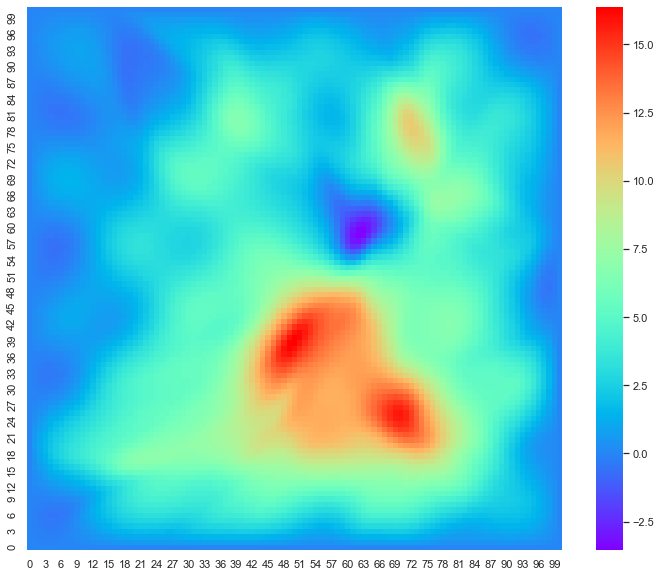

In [40]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})

# plot the heatmap of u_hat
ax = sns.heatmap(u_hat, cmap="rainbow")
ax.invert_yaxis()
plt.show()
